# Import CSV File

In [1]:
import csv 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text

# Always display all rows
pd.set_option('display.max_columns', None) 

# Always display all columns
pd.set_option('display.max_rows', None) 

# Read csv file
df = pd.read_csv('feature_engineered_tennis_data.csv')

# Change format of tournament date column
df['tournament_date'] = pd.to_datetime(df['tournament_date'])

### Feature Selection

In [2]:
# Columns selected as features for model
feature_cols = [
#'tournament_level_id',
#'surface_id',
#'p1_hand_id',
#'p2_hand_id',
#'p1_age_diff',
#'p1_height_diff',
#'p1_h2h_wins_before_total_diff',
'p1_elo_diff_before',
'p1_elo_rolling_last5_diff_before',
'p1_elo_rolling_last10_diff_before',
'p1_elo_rolling_last20_diff_before',
'p1_surface_elo_diff_before',
'p1_surface_elo_rolling_last5_diff_before',
'p1_surface_elo_rolling_last10_diff_before',
'p1_surface_elo_rolling_last20_diff_before',
'p1_total_matches_played_before_diff',
]

# Assign independant features (feature_cols) and dependant feature (result)
X = df[feature_cols]
y = df['result']

### Assign Training, Validation and Test Data

In [3]:
train = df[df['tournament_date'].dt.year <= 2018]
val = df[df['tournament_date'].dt.year == 2019]
test = df[df['tournament_date'].dt.year >= 2020]

X_train, y_train = train[feature_cols], train['result'] 
X_val, y_val = val[feature_cols], val['result'] 
X_test, y_test = test[feature_cols], test['result'] 

### Testing DecisionTreeDepths

In [4]:
# List of maximum tree depths to test
max_depths = [1,2,3,4,5,6,7,8,9,10]

# Loop through each depth value in max_depths list
for i in max_depths:
    # Create decision tree models with different max_depth values
    tree = DecisionTreeClassifier(
        max_depth = i,
        random_state = 42
    )
    
    # Train decision tree on the training data
    tree.fit(X_train, y_train)

    # Generate predictions on the validation data
    val_predictions = tree.predict(X_val)

    # Print accuracy for tree with assigned max_depth
    print(f"Validation Accuracy for Max Depth {i}:", round(accuracy_score(y_val, val_predictions), 3))

Validation Accuracy for Max Depth 1: 0.621
Validation Accuracy for Max Depth 2: 0.621
Validation Accuracy for Max Depth 3: 0.621
Validation Accuracy for Max Depth 4: 0.628
Validation Accuracy for Max Depth 5: 0.627
Validation Accuracy for Max Depth 6: 0.638
Validation Accuracy for Max Depth 7: 0.641
Validation Accuracy for Max Depth 8: 0.639
Validation Accuracy for Max Depth 9: 0.639
Validation Accuracy for Max Depth 10: 0.637


###### The decision tree has 62% accuracy after max_depth = 1, the model is currently using one feature which seperate winners and losers better than 50/50. Adding greater depth makes the model marginally better until 5, afterwhich the accuracy decreases - overfitting data!

In [5]:
# Create decision tree model with max_depth = 5
tree = DecisionTreeClassifier(
    max_depth = 5,
    random_state = 42)

# Train decision tree on the training data
tree.fit(X_train, y_train)

# Generate predictions on the validation data
val_predictions = tree.predict(X_val)

# Print accuracy for tree with assigned max_depth
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy:", round(val_accuracy, 3))

# Combine training and validation data
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# Create decision tree for retraining on both the training and validation sets
new_tree = DecisionTreeClassifier(
    max_depth = 5,
    random_state = 42)

# Retrain on training and validation sets
new_tree.fit(X_trainval, y_trainval)

# Generate predictions on the unseen test data
test_predictions = new_tree.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy on unseen data:", round(test_accuracy, 3))

Validation Accuracy: 0.627
Accuracy on unseen data: 0.632


### Optimizing Decision Tree Using Grid Search

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit, GridSearchCV

# Combining training and validation data because GridSearchCV takes one set of data that is divided into training and validation data later 
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

# Creates an array of -1s and 0s, tells grid search which rows of the X_trainval and y_trainval dataframes are training and validation data
test_fold = [-1]*len(X_train) + [0]*len(X_val)

# Create a PredefinedSplit object that enforces custom train/validation split
ps = PredefinedSplit(test_fold)

# Define the parameter grid for decision tree classifier hyperparameter tuning
param_grid = {
    # Maxium depth of the tree
    "max_depth": [2,4,6],
    # Maximum number of samples required to split a node (must have x samples to be split further)
    # If a small value, tree can keep splitting on very small groups and can risk overfitting
    "min_samples_split": [0.1, 0.2, 0.3, 0.4, 0.5],
    # Minimum number of samples required to be at the leaf node
    # Every terminal leaf must contain this number of samples
    "min_samples_leaf": [1e-2,1.5e-2,1e-1],
    # Number of features to consider when looking for the best split
    "max_features": [1,2,4,6,8,10,None],
    "criterion": ["entropy", "gini"],
    "ccp_alpha": [1e-2, 1e-3, 1e-4]
}

# Create decision tree classifier model
grid_tree = DecisionTreeClassifier(random_state = 42)

# Set up grid search cv (cross-validation) to tune decision tree hyperparameters
grid = GridSearchCV(
    # Decision tree classifier model
    estimator = grid_tree, 
    # Dictionary of hyperparameters to search
    param_grid=param_grid,
    # Optimises for the proportion of correct predictions
    scoring="accuracy",
    # Custom training/validation split
    cv=ps,
    # Use all CPUs
    n_jobs=-1
)

grid.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid.best_params_)
print("Val Accuracy:", grid.best_score_)

Best hyperparameters: {'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 0.01, 'min_samples_split': 0.1}
Val Accuracy: 0.6357821283194417


In [18]:
new_grid_tree = DecisionTreeClassifier(
    max_depth = 6,
    min_samples_split = 0.1,
    min_samples_leaf = 0.01,
    max_features = 8,
    criterion = 'gini',
    ccp_alpha = 0.0001,
    random_state = 42)

new_grid_tree.fit(X_trainval, y_trainval)

test_predictions = new_grid_tree.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy on unseen data:", round(test_accuracy, 3))

Accuracy on unseen data: 0.635


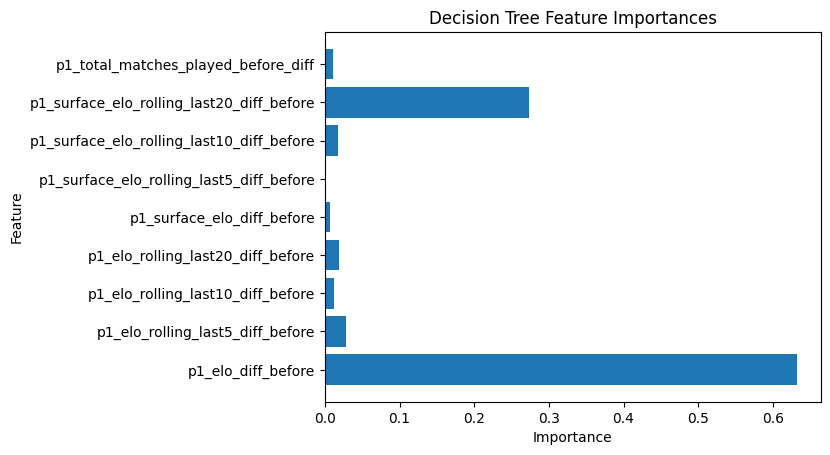

In [19]:
import matplotlib.pyplot as plt

importances = new_grid_tree.feature_importances_
plt.barh(feature_cols, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Decision Tree Feature Importances")
plt.show()

In [20]:
print(export_text(new_grid_tree, feature_names=feature_cols, max_depth=6, show_weights=True))

|--- p1_elo_diff_before <= -0.50
|   |--- p1_surface_elo_rolling_last20_diff_before <= -89.50
|   |   |--- p1_surface_elo_rolling_last10_diff_before <= -147.50
|   |   |   |--- weights: [3836.00, 769.00] class: 0
|   |   |--- p1_surface_elo_rolling_last10_diff_before >  -147.50
|   |   |   |--- weights: [3675.00, 1501.00] class: 0
|   |--- p1_surface_elo_rolling_last20_diff_before >  -89.50
|   |   |--- p1_elo_diff_before <= -74.50
|   |   |   |--- p1_elo_rolling_last10_diff_before <= -18.50
|   |   |   |   |--- p1_total_matches_played_before_diff <= 15.50
|   |   |   |   |   |--- weights: [4297.00, 2082.00] class: 0
|   |   |   |   |--- p1_total_matches_played_before_diff >  15.50
|   |   |   |   |   |--- weights: [1381.00, 942.00] class: 0
|   |   |   |--- p1_elo_rolling_last10_diff_before >  -18.50
|   |   |   |   |--- weights: [335.00, 391.00] class: 1
|   |   |--- p1_elo_diff_before >  -74.50
|   |   |   |--- p1_surface_elo_rolling_last20_diff_before <= 64.50
|   |   |   |   |--- 

In [25]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=150,     # fewer trees during search (faster)
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

param_dist = {
    "max_depth": [6, 8, 10, None],
    "min_samples_leaf": [5, 10, 20, 50, 100],
    "min_samples_split": [2, 5, 10, 25, 50],
    "max_features": ["sqrt", "log2", 0.5, None],
    "ccp_alpha": [0.0, 1e-4, 1e-3],
    "max_samples": [0.6, 0.75, 0.9],   # per-tree subsample → faster & regularizes
}

rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,                 # try ~30 random combos instead of 1,890
    scoring="accuracy",
    cv=ps,                    # your PredefinedSplit
    n_jobs=-1,
    random_state=42,
    verbose=2
)

rs.fit(X_trainval, y_trainval)
print("Best params (search):", rs.best_params_)
print("Val Accuracy (search):", rs.best_score_)

# Final refit on train+val with more trees
best = rs.best_params_.copy()
best["n_estimators"] = 500
rf_final = RandomForestClassifier(n_jobs=-1, random_state=42, **best)
rf_final.fit(X_trainval, y_trainval)

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Best params (search): {'min_samples_split': 50, 'min_samples_leaf': 10, 'max_samples': 0.9, 'max_features': None, 'max_depth': None, 'ccp_alpha': 0.0}
Val Accuracy (search): 0.6715448730374104


RandomForestClassifier(max_features=None, max_samples=0.9, min_samples_leaf=10,
                       min_samples_split=50, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [34]:
import numpy as np

# 1) Train on TRAIN only
model = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=10,
    min_samples_split=50,
    max_features=None,   # consider "sqrt" later
    ccp_alpha=0,
    n_estimators=300,    # more stable
    n_jobs=-1,
    random_state=42
)
model.fit(X_train, y_train)

# 2) Pick threshold on VALIDATION
val_proba = model.predict_proba(X_val)[:, 1]
ths = np.linspace(0.05, 0.95, 181)
best_t, best_val_acc = max(
    ((t, accuracy_score(y_val, (val_proba >= t).astype(int))) for t in ths),
    key=lambda x: x[1]
)

# 3) Refit FINAL model on TRAIN+VAL with same hyperparams (NOT re-tuning threshold)
final_model = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=10,
    min_samples_split=50,
    max_features=None,
    ccp_alpha=0,
    n_estimators=500,
    n_jobs=-1,
    random_state=42
).fit(X_trainval, y_trainval)

# 4) Evaluate on TEST using the fixed threshold from step 2
test_proba = final_model.predict_proba(X_test)[:, 1]
test_preds_opt = (test_proba >= best_t).astype(int)
print(f"Best threshold (from val): {best_t:.3f}")
print("Test Acc @best threshold:", accuracy_score(y_test, test_preds_opt))
print("Test ROC-AUC:", roc_auc_score(y_test, test_proba))


Best threshold (from val): 0.505
Test Acc @best threshold: 0.6757199583638537
Test ROC-AUC: 0.7391195706471327
